In [ ]:
 !pip install segmentation-models-pytorch
 !pip install pytorch-lightning==1.5.4
 !pip install torchtext==0.6.0
 !pip install aspose-zip

In [2]:
import zipfile

zip_file_path = 'Tigers_dataset_350.zip'
# Распаковать архив в текущую папку
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import numpy as np

from pprint import pprint
from torch.utils.data import DataLoader
from PIL import Image

In [4]:
class TigerDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None, image_size = 256):

        assert mode in {"train", "valid", "test"}

        self.root = root
        self.mode = mode
        self.transform = transform
        self.image_size = image_size
        self.images_directory = os.path.join(self.root, "images")
        self.masks_directory = os.path.join(self.root, "annotations", "trimaps")

        self.filenames = self._read_split()  # read train/valid/test splits

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        filename = self.filenames[idx]
        image_path = os.path.join(self.images_directory, filename + ".jpg")
        mask_path = os.path.join(self.masks_directory, filename + ".png")

        image = np.array(Image.open(image_path).convert("RGB"))
        trimap = np.array(Image.open(mask_path))
        mask = self._preprocess_mask(trimap)

        sample = dict(image=image, mask=mask, trimap=trimap)

        image = np.array(Image.fromarray(sample["image"]).resize((self.image_size, self.image_size ), Image.BILINEAR))
        mask = np.array(Image.fromarray(sample["mask"]).resize((self.image_size, self.image_size ), Image.NEAREST))
        trimap = np.array(Image.fromarray(sample["trimap"]).resize((self.image_size, self.image_size ), Image.NEAREST))
        # convert to other format HWC -> CHW
        sample["image"] = np.moveaxis(image, -1, 0)
        sample["mask"] = np.expand_dims(mask, 0)
        sample["trimap"] = np.expand_dims(trimap, 0)

                # resize images

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    @staticmethod
    def _preprocess_mask(mask):
        mask = mask.astype(np.float32)/mask.max()
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask

    def _read_split(self):
        split_filename = "test.txt" if self.mode == "test" else "trainval.txt"
        split_filepath = os.path.join(self.root, "annotations", split_filename)
        with open(split_filepath) as f:
            split_data = f.read().strip("\n").split("\n")
        filenames = [x.split(" ")[0] for x in split_data]
        if self.mode == "train":  # 90% for train
            filenames = [x for i, x in enumerate(filenames) if i % 10 != 0]
        elif self.mode == "valid":  # 10% for validation
            filenames = [x for i, x in enumerate(filenames) if i % 10 == 0]
        return filenames

In [5]:
# init train, val, test sets
root = "."
train_dataset = TigerDataset(root, "train")
valid_dataset = TigerDataset(root, "valid")
test_dataset = TigerDataset(root, "test")

train_dataset1 = train_dataset
# train_dataset1[0]["mask"][0][0][0] = 1.
print(len(train_dataset1))

252


In [6]:
train_dataset[0]['image'].shape, train_dataset[0]['mask'].shape, train_dataset[0]['trimap'].shape
mask = train_dataset[0]['mask']
mask.min(), mask.max()

(0.0, 1.0)

In [7]:
# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=n_cpu)

Train size: 252
Valid size: 28
Test size: 70


In [8]:
# dir(Image)

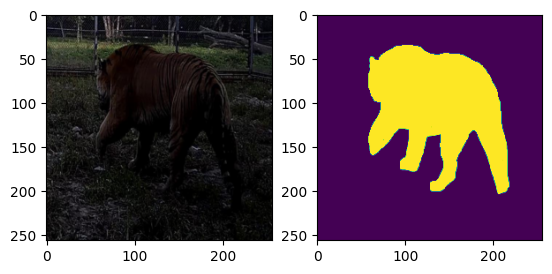

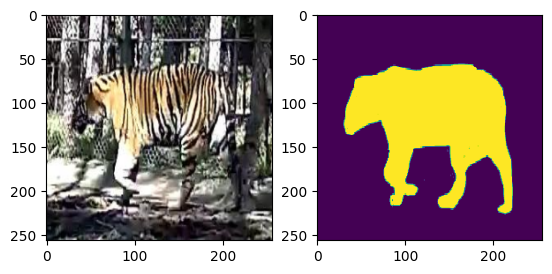

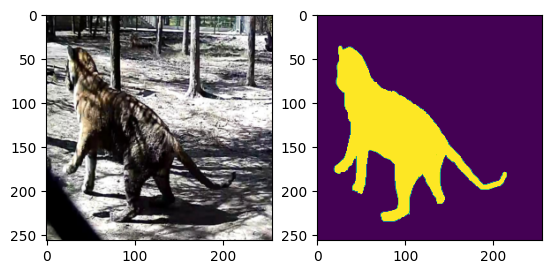

In [9]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [10]:
class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [11]:
model = PetModel("Unet", "resnet34", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 208MB/s]


In [12]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=100,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.8951679468154907,
  'valid_per_image_iou': 0.897937536239624}]


In [14]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.9000231027603149,
  'test_per_image_iou': 0.8995741605758667}]


In [15]:
pr_masks.min()

NameError: ignored

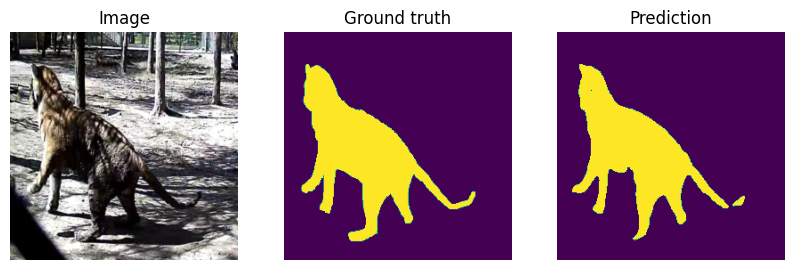

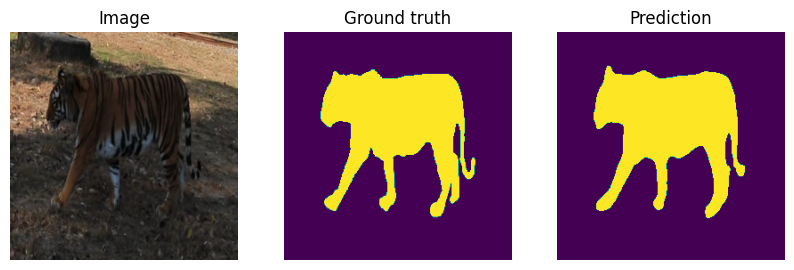

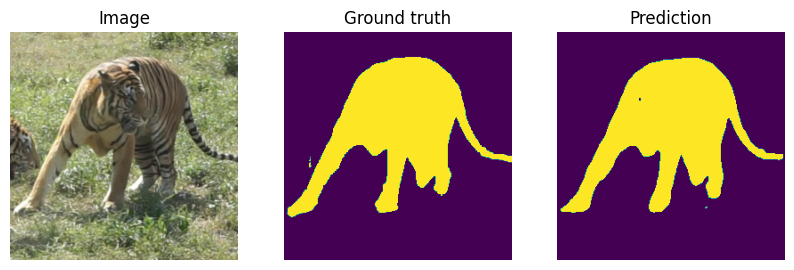

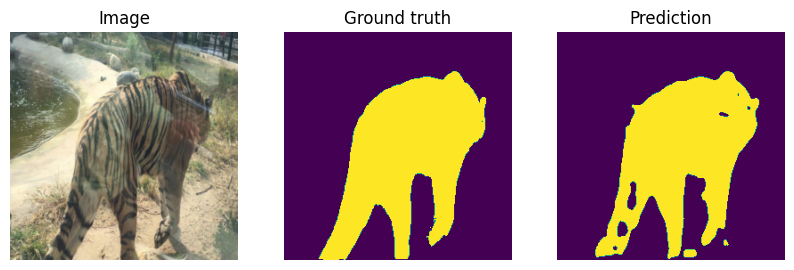

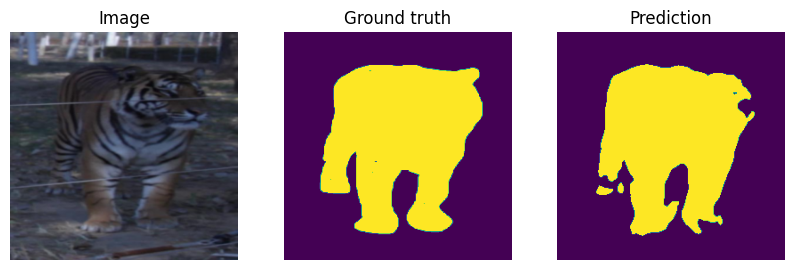

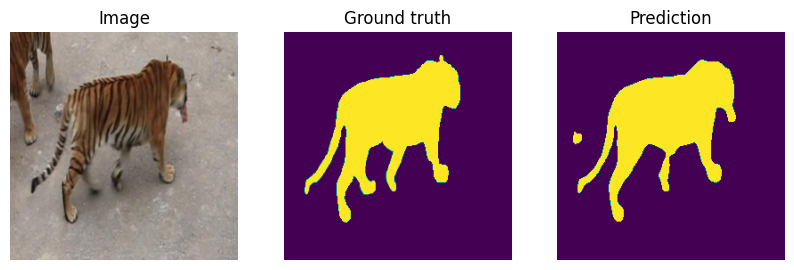

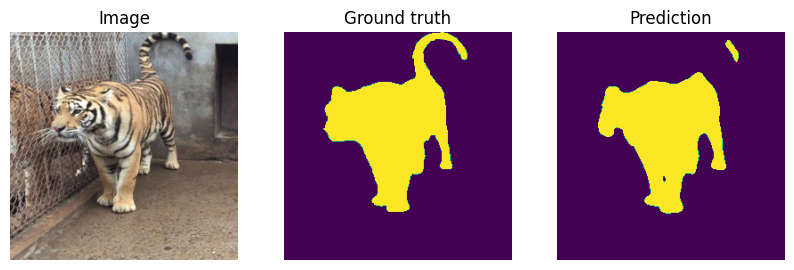

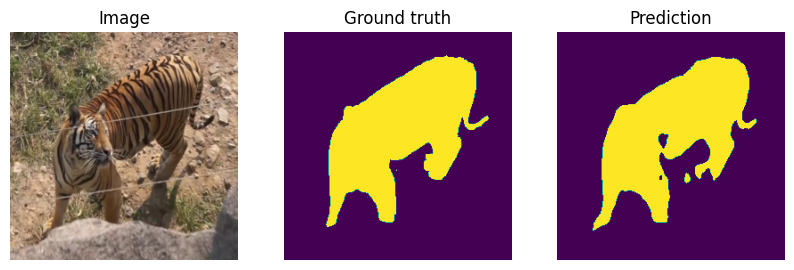

In [16]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
#Порог для маски
pr_masks[pr_masks>0.8] = 1
pr_masks[pr_masks<0.8] = 0

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [18]:
other_dataset = TigerDataset('.', "test")
test_dataloader = DataLoader(other_dataset, batch_size=8, shuffle=False, num_workers=n_cpu)